# Setup

In [21]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [36]:
"""
Change directory to where this file is located
"""
%cd 'C:/Users/user/Desktop/mldl1/hw4'

[WinError 123] 파일 이름, 디렉터리 이름 또는 볼륨 레이블 구문이 잘못되었습니다: "'C:/Users/user/Desktop/mldl1/hw4'"
c:\Users\user\Desktop\mldl1\hw4


In [37]:
import math
import random
from pathlib import Path
import sys

from data.data import prepareData

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
"""
import modules you need
"""


'\nimport modules you need\n'

## Util

**Do NOT Modify** code blocks in this section

In [39]:
SEED = 1234
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [40]:
def train(model, iterator, optimizer, loss_fn, clip,scheduler):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src = batch[0].to(DEVICE)
        trg = batch[1].to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg)
        loss = loss_fn(output, trg[:,1:])
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    scheduler.step()

    return epoch_loss / len(iterator)

In [41]:
def evaluate(model, iterator, loss_fn):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch[0].to(DEVICE)
            trg = batch[1].to(DEVICE)
            output = model(src, trg)
            loss = loss_fn(output, trg[:,1:])
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [42]:
def plot_history(history):
    plt.figure(figsize=(2 * 13, 4))
    plt.subplot(1, 5, 1)
    plt.title("Training and Validation Loss")
    plt.plot(history['train_PPL'], label="train_PPL")
    plt.plot(history['val_PPL'], label="val_PPL")
    plt.xlabel("iterations")
    plt.ylabel("PPL")
    plt.legend()
    plt.subplot(1, 5, 2)
    plt.title("Learning Rate")
    plt.plot(history['lr'], label="learning rate")
    plt.xlabel("iterations")
    plt.ylabel("LR")
    plt.show()

## Dataset & Dataloader

**Do NOT Modify** code blocks in this section

In [43]:
MAX_LENGTH = 10
BATCH_SIZE = 64

TRAIN_RATIO = 0.7 # train dataset ratio, should be a float in (0, 0.8]
VALID_RATIO = 0.8 - TRAIN_RATIO

SOS_token = 0
EOS_token = 1

In [44]:
class TranslateDataset(Dataset):
    def __init__(self, max_length=10, fra2eng=True):
        self.input_lang, self.output_lang, self.pairs = prepareData('eng', 'fra', max_length=max_length, reverse=fra2eng)
        self.max_length = max_length
        self.input_lang.addWord('PAD')
        self.output_lang.addWord('PAD')
        self.input_lang_pad = self.input_lang.word2index['PAD']
        self.output_lang_pad = self.output_lang.word2index['PAD']

        print("\n")
        print("This is data example")
        print(random.choice(self.pairs))

        print("\n")
        print("This is index of PAD token for each language")
        print(f"fra {self.output_lang.word2index['PAD']}")
        print(f"eng {self.input_lang.word2index['PAD']}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        x, y = self._tensorsFromPair(pair)
        return x, y

    def _tensorFromSentence(self, lang, sentence):
        indexes = [lang.word2index[word] for word in sentence.split(' ')]
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

    def _tensorsFromPair(self, pair):
        input_tensor = self._tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self._tensorFromSentence(self.output_lang, pair[1])
        return (input_tensor, target_tensor)

    def collate_fn(self, data):
        x_batch = []; y_batch = []

        for x, y in data:
            if x.shape[0] < self.max_length-1:
                x = torch.cat([x, self.input_lang_pad*torch.ones((self.max_length-1 - x.shape[0], 1), dtype=x.dtype)])
            elif x.shape[0] > self.max_length-1:
                x = x[:self.max_length-1]
            if y.shape[0] < self.max_length-1:
                y = torch.cat([y, self.output_lang_pad*torch.ones((self.max_length-1 - y.shape[0], 1), dtype=y.dtype)])
            elif y.shape[0] > self.max_length-1:
                y = y[:self.max_length-1]

            x_batch.append(torch.cat([torch.tensor([SOS_token]), x.squeeze(1)]))
            y_batch.append(torch.cat([torch.tensor([SOS_token]), y.squeeze(1)]))

        return torch.stack(x_batch), torch.stack(y_batch)

dataset = TranslateDataset(max_length=MAX_LENGTH)

train_size = int(len(dataset)*TRAIN_RATIO)
valid_size = int(len(dataset)*VALID_RATIO)
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, len(dataset)-(train_size+valid_size)],)
print("\n")
print(f"This is dataset_size: {len(dataset)}")
print(f"train_size: {train_size}")
print(f"valid_data: {valid_size}")
print(f"test_data: {len(test_data)}")

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


This is data example
['tu me fais de l ombre .', 'you re blocking my light .']


This is index of PAD token for each language
fra 2803
eng 4345


This is dataset_size: 10599
train_size: 7419
valid_data: 1059
test_data: 2121


## Implement LSTM Seq2Seq Model

In [45]:
class LSTMEncoder(nn.Module):
    def __init__(self, in_dim, emb_dim, hid_dim):
        super(LSTMEncoder, self).__init__()
        self.embedding = nn.Embedding(in_dim, emb_dim)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)

    def forward(self, input, hidden, cell):
        '''
        Q2 - (a)
        Implement forward method of LSTM Encoder Module

        INPUT
        - input: input sentence, (B, max_len)
        - hidden: initialized hidden state, (1, B, hid_dim)
        - cell: initialized cell state, (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need. (e.g. hidden states of encoder, etc.)
        '''
        ################### YOUR CODE ###################
        embedded = self.embedding(input)
        output, (hn, cn)= self.lstm(embedded, (hidden, cell))
        #output = (B, max_len, hid_dim),hn= (1, B, hid_dim), cn= (1, B, hid_dim)
        return output, hn,cn
        #################################################

In [46]:
class AttnLSTMDecoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, out_dim, dropout, enc_hiddens=None):
        super(AttnLSTMDecoder, self).__init__()
        self.enc_hiddens = enc_hiddens # encoder output
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(out_dim, emb_dim)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim + hid_dim, hid_dim)
        self.tanh = nn.Tanh()
        self.classifier = nn.Linear(hid_dim, out_dim)
        self.hid_dim = hid_dim
        self.emb_dim = emb_dim

    def forward(self, input, hidden, cell):
        '''
        Q2 - (a)
        Implement forward method of LSTM Decoder Module with dot-product attention
        Before implementing LSTM layer, make sure to feed the concatenated input into Linear and tanh activation layer.
        This will allow the concatenated input to be resized from (B, hid_dim + hid_dim) into (B, hid_dim)

        INPUT
        - input: a token of input sentence (B, 1)
        - hidden: previous hidden state (B, hid_dim)
        - cell: previous cell state (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need.
        Some examples below
        - predicted token embedding (N, emb_dim)
        - current hidden state
        - current cell state
        '''

        ################### YOUR CODE ###################
        input = self.embedding(input) # (B, 1, emb_dim)
      
        hidden = hidden.squeeze(0) # (B, hid_dim)
        cell = cell.squeeze(0) # (B, hid_dim)
        
        # Calculate attention scores (B, seq_len) 
        attn_scores = torch.bmm(self.enc_hiddens, hidden.unsqueeze(2)).squeeze(2) # (B, seq_len)

        # Compute attention weights
        attn_weights = F.softmax(attn_scores, dim=1) # (B, seq_len)

        # Compute context vector
        context = torch.bmm(attn_weights.unsqueeze(1), self.enc_hiddens).squeeze(1) # (B, hid_dim)

        # Concatenate input and context and pass through Linear and Tanh layers
        concat_input = torch.cat((hidden, context), dim=1) # (B, hid_dim + hid_dim)
        concat_input = self.tanh(self.fc(concat_input)) # (B, hid_dim)
        concat_input = self.dropout(concat_input)
        
        # LSTM layer
        output, (hidden, cell) = self.lstm(input, (concat_input.unsqueeze(0), cell.unsqueeze(0)))
        # output: (B, 1, hid_dim)
        # hidden, cell: (1, B, hid_dim)

        # Classifier to generate predicted token embedding
        prediction = self.classifier(output.squeeze(1)) # (B, out_dim)

        return prediction, hidden, cell
        #################################################

In [51]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim, hid_dim, device, dropout):
        super(LSTMSeq2Seq, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.device = device
        self.dropout = nn.Dropout(dropout)
        self.encoder = LSTMEncoder(in_dim, emb_dim, hid_dim)
        self.decoder = AttnLSTMDecoder(emb_dim, hid_dim, out_dim, dropout)

    def forward(self, src, trg):
        '''
        Q2 - (b)
        Implement forward method of LSTM Seq2Seq Module
        (Decoder module should attend encoder's outputs using dot product.)

        INPUT
        - src: source language batched data (B, max_len)
        - trg: target language batched data (B, max_len)

        OUTPUT
        - output of one-hot prediction (B, out_dim, max_len)
        '''
        ################### YOUR CODE ###################
        batch_size, mx_len = trg.shape
        
        # Encoder (start from zero-hidden & zero-cell states)
        h0 = torch.zeros(1, batch_size, self.hid_dim).to(self.device)
        c0 = torch.zeros(1, batch_size, self.hid_dim).to(self.device)
        hiddens,hn,cn = self.encoder(src, h0, c0)
        hn = hn.squeeze(0)
        # Decoder
        self.decoder.enc_hiddens = hiddens # set encoder's hidden states,(batch_size, mx_len, hid_dim)
        outputs = [] # to store each decoder's output
        
        x = trg[:, 0]#<sos> token as first input, shape = (batch_size, 1)
        x = x.unsqueeze(1)
        
        for t in range(1, mx_len): # for each t'th token, get decoder outputs
            output,hn,cn = self.decoder(x, hn, cn)
            #output shape = (batch_size, out_dim)
            x = torch.argmax(output, dim=1).unsqueeze(1)
            #output shape = (mx_len, batch_size, out_dim)
            outputs.append(output)   
       
        
        outputs = torch.stack(outputs, dim=2)
        
        return outputs
        #################################################

## Training

In [52]:
'''
Q2 - (c)
Train your Seq2Seq model and plot perplexities and learning rates.
Upon successful training, the test perplexity should be less than 7.
Briefly report your hyperparameters and results on test dataset.
Make sure your results are printed in your submitted file.
'''

'\nQ2 - (c)\nTrain your Seq2Seq model and plot perplexities and learning rates.\nUpon successful training, the test perplexity should be less than 7.\nBriefly report your hyperparameters and results on test dataset.\nMake sure your results are printed in your submitted file.\n'

In [55]:
# experiment various methods for better performance
# you can modify the codes in this block

in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 2048
emb_dim = 2048
dropout = 0.4
learning_rate = 0.001
N_EPOCHS = 10
valid_every=1
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.6)
loss_fn = nn.CrossEntropyLoss(ignore_index = dataset.output_lang_pad)

Epoch: 01 | LR: 0.001000
	Train Loss: 3.242 | Train PPL:  25.581
	 Val. Loss: 2.752 |  Val. PPL:  15.681
Epoch: 02 | LR: 0.001000
	Train Loss: 2.419 | Train PPL:  11.237
	 Val. Loss: 2.404 |  Val. PPL:  11.068
Epoch: 03 | LR: 0.001000
	Train Loss: 1.946 | Train PPL:   6.999
	 Val. Loss: 2.167 |  Val. PPL:   8.735
Epoch: 04 | LR: 0.001000
	Train Loss: 1.533 | Train PPL:   4.631
	 Val. Loss: 1.997 |  Val. PPL:   7.364
Epoch: 05 | LR: 0.001000
	Train Loss: 1.172 | Train PPL:   3.230
	 Val. Loss: 1.871 |  Val. PPL:   6.496
Epoch: 06 | LR: 0.001000
	Train Loss: 0.882 | Train PPL:   2.415
	 Val. Loss: 1.801 |  Val. PPL:   6.056
Epoch: 07 | LR: 0.001000
	Train Loss: 0.634 | Train PPL:   1.886
	 Val. Loss: 1.744 |  Val. PPL:   5.720
Epoch: 08 | LR: 0.001000
	Train Loss: 0.445 | Train PPL:   1.560
	 Val. Loss: 1.751 |  Val. PPL:   5.758
Epoch: 09 | LR: 0.001000
	Train Loss: 0.310 | Train PPL:   1.363
	 Val. Loss: 1.755 |  Val. PPL:   5.785
Epoch: 10 | LR: 0.000600
	Train Loss: 0.221 | Train PPL

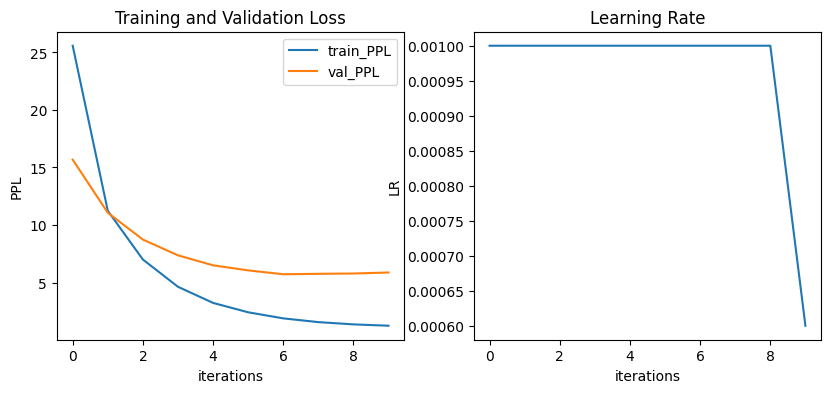

In [56]:
# Train your model
# you can modify the codes in this block
history = {'train_PPL':[], 'val_PPL':[], 'lr':[]}

for epoch in range(N_EPOCHS):

    train_loss = train(model, train_dataloader, optimizer, loss_fn, 1,scheduler)
    
    print(f'Epoch: {epoch+1:02} | LR: {optimizer.param_groups[0]["lr"]:.6f}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(model, valid_dataloader, loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model.decoder.t=0
            torch.save(model.state_dict(), 'lstm-attn-model.pt')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        history['train_PPL'].append(math.exp(train_loss))
        history['val_PPL'].append(math.exp(valid_loss))
        history['lr'].append(optimizer.param_groups[0]['lr'])

plot_history(history)

In [59]:
# Test your model
torch.save(model.state_dict(), 'lstm-attn-model.pt')
loaded_model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
loaded_model.load_state_dict(torch.load('lstm-attn-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {valid_loss:.3f} |  Test. PPL: {math.exp(valid_loss):7.3f}')

	 Test. Loss: 1.770 |  Test. PPL:   5.872


Briefly report your hyperparameters and results on test datasets.  

hid_dim = 2048
emb_dim = 2048
dropout = 0.4
learning_rate = 0.001
N_EPOCHS = 10
optimizer = AdamW
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.6)-> not used, N_epochs <= step_size.


Larger model with more hidden units and layers (hid_dim=2048, emb_dim=2048) performed better than smaller model (hid_dim=512, emb_dim=512) even with smaller epoch